<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/GRU/GRU_EURUSD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 119, done.
remote: Counting objects: 100% (119/119), done.
remote: Compressing objects: 100% (114/114), done.
remote: Total 119 (delta 53), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (119/119), 107.55 KiB | 5.66 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Tue Jul 13 12:55:07 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [8]:
# storing the file to be read as a string
in_str = 'EURUSD'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'GRU'
# setting our window_length to be 30 days
window_len = 30

In [9]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [10]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 8.1MB/s 
     |████████████████████████████████| 102kB 11.9MB/s 
     |████████████████████████████████| 143kB 38.9MB/s 
     |████████████████████████████████| 174kB 29.5MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


In [11]:
!pip install wandb -qq

In [12]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [13]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'dropout': {
            'values': [0.2, 0.3, 0.4]
        },
        'input_size': {
            'values': [25, 50, 100]
        },
        'hidden_size': {
            'values': [25, 50, 100]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'sgd']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [14]:
# The sweep calls this function with each set of hyperparameters
def train():
    # Default values for hyper-parameters we're going to sweep over
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 50,
        'hidden_size': 50,
        'learning_rate': 0.005,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    
    # Define the model architecture - This is a simplified version of the VGG19 architecture
    model = Sequential()
    
    # input layer
    model.add(GRU(units=config.input_size,
                  activation=config.activation,
                  return_sequences=True,
                  input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # hidden layer
    model.add(GRU(units=config.hidden_size))
    model.add(Dropout(config.dropout))
    model.add(Dense(units=1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [15]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_GRU')

Create sweep with ID: d67zmip9
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_GRU/sweeps/d67zmip9


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_GRU')

wandb: Agent Starting Run: 74b04w47 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam
wandb: Currently logged in as: acse-jaq15 (use `wandb login --relogin` to force relogin)


Epoch 1/50
32/32 [==============================] - 30s 108ms/step - loss: 0.1000 - mean_squared_error: 0.1000 - mean_absolute_error: 0.2231 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0560
Epoch 2/50
32/32 [==============================] - 2s 78ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - mean_absolute_error: 0.0400 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0498
Epoch 3/50
32/32 [==============================] - 2s 73ms/step - loss: 0.0021 - mean_squared_error: 0.0021 - mean_absolute_error: 0.0348 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0574
Epoch 4/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0386 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0490
Epoch 5/50
32/32 [==============================] - 2s 78ms/step - loss: 0.0026 - mean_squared_err

epoch,49
loss,0.00123
mean_squared_error,0.00123
mean_absolute_error,0.02611
val_loss,0.00222
val_mean_squared_error,0.00222
val_mean_absolute_error,0.03752
_runtime,158
_timestamp,1626181135
_step,49
best_val_loss,0.00212


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▅█▄▄▄▄▄▄▃▃▃▃▄▃▅▄▂▄▂▂▂▃▁▂▁▁▂▁▁▁▂▁▁▂▁▃▂▃▁
val_mean_squared_error,▇▅█▄▄▄▄▄▄▃▃▃▃▄▃▅▄▂▄▂▂▂▃▁▂▁▁▂▁▁▁▂▁▁▂▁▃▂▃▁
val_mean_absolute_error,█▅█▅▅▅▄▄▅▄▄▄▃▄▄▆▄▃▄▂▂▂▃▁▂▂▁▂▁▁▁▁▁▂▃▁▄▂▄▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: owy4wxg2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 5s 215ms/step - loss: 0.0908 - mean_squared_error: 0.0908 - mean_absolute_error: 0.2176 - val_loss: 0.0170 - val_mean_squared_error: 0.0170 - val_mean_absolute_error: 0.1163
Epoch 2/200
8/8 [==============================] - 1s 80ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.1010 - val_loss: 0.0149 - val_mean_squared_error: 0.0149 - val_mean_absolute_error: 0.0983
Epoch 3/200
8/8 [==============================] - 1s 80ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - mean_absolute_error: 0.0814 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0535
Epoch 4/200
8/8 [==============================] - 1s 76ms/step - loss: 0.0097 - mean_squared_error: 0.0097 - mean_absolute_error: 0.0693 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0475
Epoch 5/200
8/8 [==============================] - 1s 84ms/step - loss: 0.0079 - mean_squared_error: 0.

epoch,163
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.03113
val_loss,0.00214
val_mean_squared_error,0.00214
val_mean_absolute_error,0.03729
_runtime,118
_timestamp,1626181261
_step,163
best_val_loss,0.00202


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 37jy3kit with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 5s 139ms/step - loss: 0.1478 - mean_squared_error: 0.1478 - mean_absolute_error: 0.2827 - val_loss: 0.0521 - val_mean_squared_error: 0.0521 - val_mean_absolute_error: 0.1693
Epoch 2/100
16/16 [==============================] - 1s 72ms/step - loss: 0.0456 - mean_squared_error: 0.0456 - mean_absolute_error: 0.1683 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1562
Epoch 3/100
16/16 [==============================] - 1s 75ms/step - loss: 0.0403 - mean_squared_error: 0.0403 - mean_absolute_error: 0.1684 - val_loss: 0.0279 - val_mean_squared_error: 0.0279 - val_mean_absolute_error: 0.1292
Epoch 4/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0339 - mean_squared_error: 0.0339 - mean_absolute_error: 0.1360 - val_loss: 0.0211 - val_mean_squared_error: 0.0211 - val_mean_absolute_error: 0.1122
Epoch 5/100
16/16 [==============================] - 1s 79ms/step - loss: 0.0264 - mean_squared

epoch,65
loss,0.0048
mean_squared_error,0.0048
mean_absolute_error,0.04763
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04718
_runtime,114
_timestamp,1626181382
_step,65
best_val_loss,0.00341


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▅▃▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 8ly3oyzq with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 7s 104ms/step - loss: 0.0806 - mean_squared_error: 0.0806 - mean_absolute_error: 0.2087 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0663
Epoch 2/200
32/32 [==============================] - 2s 76ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0589 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0467
Epoch 3/200
32/32 [==============================] - 2s 78ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0474 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0455
Epoch 4/200
32/32 [==============================] - 2s 75ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0438 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0464
Epoch 5/200
32/32 [==============================] - 3s 79ms/step - loss: 0.0044 - mean_squared

epoch,70
loss,0.00184
mean_squared_error,0.00184
mean_absolute_error,0.03176
val_loss,0.00293
val_mean_squared_error,0.00293
val_mean_absolute_error,0.04332
_runtime,185
_timestamp,1626181575
_step,70
best_val_loss,0.00286


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: zesu3zya with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 6s 42ms/step - loss: 0.1019 - mean_squared_error: 0.1019 - mean_absolute_error: 0.2210 - val_loss: 0.0137 - val_mean_squared_error: 0.0137 - val_mean_absolute_error: 0.0956
Epoch 2/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0301 - mean_squared_error: 0.0301 - mean_absolute_error: 0.1248 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0641
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0164 - mean_squared_error: 0.0164 - mean_absolute_error: 0.0869 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0476
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0148 - mean_squared_error: 0.0148 - mean_absolute_error: 0.0778 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0469
Epoch 5/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0120 - mean_squared_

epoch,92
loss,0.00301
mean_squared_error,0.00301
mean_absolute_error,0.03679
val_loss,0.00275
val_mean_squared_error,0.00275
val_mean_absolute_error,0.04237
_runtime,62
_timestamp,1626181644
_step,92
best_val_loss,0.00262


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: motwt9wn with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 8s 110ms/step - loss: 0.0714 - mean_squared_error: 0.0714 - mean_absolute_error: 0.1810 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0634
Epoch 2/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0511 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0448
Epoch 3/50
32/32 [==============================] - 3s 80ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0386 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0453
Epoch 4/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0434 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - val_mean_absolute_error: 0.0447
Epoch 5/50
32/32 [==============================] - 3s 79ms/step - loss: 0.0039 - mean_squared_erro

epoch,44
loss,0.00206
mean_squared_error,0.00206
mean_absolute_error,0.03241
val_loss,0.00274
val_mean_squared_error,0.00274
val_mean_absolute_error,0.04204
_runtime,156
_timestamp,1626181809
_step,44
best_val_loss,0.00234


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▃▂▂▄▂▅▂▂▂▂▂▄▂▂▁▁▂▂▁▁▂▁▂▂▁▄▁▁▁▂
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▃▂▂▄▂▅▂▂▂▂▂▄▂▂▁▁▂▂▁▁▂▁▂▂▁▄▁▁▁▂
val_mean_absolute_error,█▃▃▃▃▃▃▃▃▃▃▃▃▄▂▅▂▃▂▂▂▄▂▂▂▁▂▂▂▁▂▁▂▂▁▄▁▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: uoayxqa2 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 144ms/step - loss: 0.0606 - mean_squared_error: 0.0606 - mean_absolute_error: 0.1698 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0666
Epoch 2/50
16/16 [==============================] - 1s 82ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0516 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - val_mean_absolute_error: 0.0442
Epoch 3/50
16/16 [==============================] - 1s 79ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0465 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0427
Epoch 4/50
16/16 [==============================] - 1s 88ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0406 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0427
Epoch 5/50
16/16 [==============================] - 1s 82ms/step - loss: 0.0034 - mean_squared_erro

epoch,49
loss,0.00162
mean_squared_error,0.00162
mean_absolute_error,0.02847
val_loss,0.00205
val_mean_squared_error,0.00205
val_mean_absolute_error,0.03638
_runtime,75
_timestamp,1626181917
_step,49
best_val_loss,0.00205


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▃▂▁▁▁▁▂▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: w25tthwo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 7s 106ms/step - loss: 0.1304 - mean_squared_error: 0.1304 - mean_absolute_error: 0.2663 - val_loss: 0.0719 - val_mean_squared_error: 0.0719 - val_mean_absolute_error: 0.1941
Epoch 2/100
32/32 [==============================] - 3s 79ms/step - loss: 0.0573 - mean_squared_error: 0.0573 - mean_absolute_error: 0.1718 - val_loss: 0.0485 - val_mean_squared_error: 0.0485 - val_mean_absolute_error: 0.1682
Epoch 3/100
32/32 [==============================] - 2s 78ms/step - loss: 0.0513 - mean_squared_error: 0.0513 - mean_absolute_error: 0.1806 - val_loss: 0.0446 - val_mean_squared_error: 0.0446 - val_mean_absolute_error: 0.1620
Epoch 4/100
32/32 [==============================] - 3s 78ms/step - loss: 0.0484 - mean_squared_error: 0.0484 - mean_absolute_error: 0.1699 - val_loss: 0.0417 - val_mean_squared_error: 0.0417 - val_mean_absolute_error: 0.1563
Epoch 5/100
32/32 [==============================] - 3s 80ms/step - loss: 0.0439 - mean_squared

epoch,99
loss,0.00558
mean_squared_error,0.00558
mean_absolute_error,0.05079
val_loss,0.00286
val_mean_squared_error,0.00286
val_mean_absolute_error,0.04309
_runtime,270
_timestamp,1626182209
_step,99
best_val_loss,0.00284


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 877pmh1z with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/100
16/16 [==============================] - 6s 141ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2443 - val_loss: 0.0193 - val_mean_squared_error: 0.0193 - val_mean_absolute_error: 0.1091
Epoch 2/100
16/16 [==============================] - 1s 78ms/step - loss: 0.0150 - mean_squared_error: 0.0150 - mean_absolute_error: 0.0845 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0576
Epoch 3/100
16/16 [==============================] - 1s 73ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - mean_absolute_error: 0.0529 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0498
Epoch 4/100
16/16 [==============================] - 2s 101ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0441 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0473
Epoch 5/100
16/16 [==============================] - 1s 80ms/step - loss: 0.0039 - mean_square

epoch,56
loss,0.00187
mean_squared_error,0.00187
mean_absolute_error,0.03277
val_loss,0.00331
val_mean_squared_error,0.00331
val_mean_absolute_error,0.04622
_runtime,83
_timestamp,1626182300
_step,56
best_val_loss,0.00309


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ev4j4778 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/200
16/16 [==============================] - 5s 69ms/step - loss: 0.1037 - mean_squared_error: 0.1037 - mean_absolute_error: 0.2335 - val_loss: 0.0132 - val_mean_squared_error: 0.0132 - val_mean_absolute_error: 0.0931
Epoch 2/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0250 - mean_squared_error: 0.0250 - mean_absolute_error: 0.1262 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0739
Epoch 3/200
16/16 [==============================] - 0s 13ms/step - loss: 0.0176 - mean_squared_error: 0.0176 - mean_absolute_error: 0.0962 - val_loss: 0.0067 - val_mean_squared_error: 0.0067 - val_mean_absolute_error: 0.0629
Epoch 4/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - mean_absolute_error: 0.0746 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0479
Epoch 5/200
16/16 [==============================] - 0s 11ms/step - loss: 0.0117 - mean_squared_

epoch,199
loss,0.00322
mean_squared_error,0.00322
mean_absolute_error,0.03857
val_loss,0.00236
val_mean_squared_error,0.00236
val_mean_absolute_error,0.03839
_runtime,50
_timestamp,1626182359
_step,199
best_val_loss,0.00217


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jboqejfo with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/100
32/32 [==============================] - 8s 116ms/step - loss: 0.1597 - mean_squared_error: 0.1597 - mean_absolute_error: 0.2947 - val_loss: 0.0250 - val_mean_squared_error: 0.0250 - val_mean_absolute_error: 0.1244
Epoch 2/100
32/32 [==============================] - 3s 84ms/step - loss: 0.0197 - mean_squared_error: 0.0197 - mean_absolute_error: 0.1162 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0516
Epoch 3/100
32/32 [==============================] - 3s 89ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - mean_absolute_error: 0.0516 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0545
Epoch 4/100
32/32 [==============================] - 3s 84ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0501 - val_loss: 0.0041 - val_mean_squared_error: 0.0041 - val_mean_absolute_error: 0.0507
Epoch 5/100
32/32 [==============================] - 3s 83ms/step - loss: 0.0051 - mean_squared

epoch,14
loss,0.00399
mean_squared_error,0.00399
mean_absolute_error,0.04537
val_loss,0.00396
val_mean_squared_error,0.00396
val_mean_absolute_error,0.04961
_runtime,51
_timestamp,1626182419
_step,14
best_val_loss,0.00388


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▂▁▁▁
_runtime,▁▂▂▃▃▄▄▅▅▅▆▇▇▇█
_timestamp,▁▂▂▃▃▄▄▅▅▅▆▇▇▇█
_step,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█


wandb: Agent Starting Run: bnbbrami with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
32/32 [==============================] - 5s 55ms/step - loss: 0.0655 - mean_squared_error: 0.0655 - mean_absolute_error: 0.1886 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0893
Epoch 2/50
32/32 [==============================] - 0s 11ms/step - loss: 0.0151 - mean_squared_error: 0.0151 - mean_absolute_error: 0.0853 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0488
Epoch 3/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0547 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0452
Epoch 4/50
32/32 [==============================] - 0s 10ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0541 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0460
Epoch 5/50
32/32 [==============================] - 0s 9ms/step - loss: 0.0058 - mean_squared_error: 

epoch,49
loss,0.00318
mean_squared_error,0.00318
mean_absolute_error,0.0396
val_loss,0.00305
val_mean_squared_error,0.00305
val_mean_absolute_error,0.04419
_runtime,26
_timestamp,1626182454
_step,49
best_val_loss,0.00303


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 4f3ej200 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 6s 211ms/step - loss: 0.1716 - mean_squared_error: 0.1716 - mean_absolute_error: 0.2993 - val_loss: 0.0337 - val_mean_squared_error: 0.0337 - val_mean_absolute_error: 0.1346
Epoch 2/50
8/8 [==============================] - 1s 87ms/step - loss: 0.0358 - mean_squared_error: 0.0358 - mean_absolute_error: 0.1318 - val_loss: 0.0107 - val_mean_squared_error: 0.0107 - val_mean_absolute_error: 0.0885
Epoch 3/50
8/8 [==============================] - 1s 86ms/step - loss: 0.0216 - mean_squared_error: 0.0216 - mean_absolute_error: 0.1097 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - val_mean_absolute_error: 0.0617
Epoch 4/50
8/8 [==============================] - 1s 94ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0787 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_mean_absolute_error: 0.0530
Epoch 5/50
8/8 [==============================] - 1s 92ms/step - loss: 0.0100 - mean_squared_error: 0.0100 

epoch,49
loss,0.00435
mean_squared_error,0.00435
mean_absolute_error,0.04413
val_loss,0.00305
val_mean_squared_error,0.00305
val_mean_absolute_error,0.04393
_runtime,45
_timestamp,1626182508
_step,49
best_val_loss,0.0028


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: trn8x5ud with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 7s 113ms/step - loss: 0.1787 - mean_squared_error: 0.1787 - mean_absolute_error: 0.3086 - val_loss: 0.0648 - val_mean_squared_error: 0.0648 - val_mean_absolute_error: 0.1886
Epoch 2/100
32/32 [==============================] - 3s 82ms/step - loss: 0.0549 - mean_squared_error: 0.0549 - mean_absolute_error: 0.1882 - val_loss: 0.0433 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1671
Epoch 3/100
32/32 [==============================] - 3s 80ms/step - loss: 0.0445 - mean_squared_error: 0.0445 - mean_absolute_error: 0.1750 - val_loss: 0.0343 - val_mean_squared_error: 0.0343 - val_mean_absolute_error: 0.1453
Epoch 4/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0375 - mean_squared_error: 0.0375 - mean_absolute_error: 0.1516 - val_loss: 0.0261 - val_mean_squared_error: 0.0261 - val_mean_absolute_error: 0.1265
Epoch 5/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0259 - mean_squared

epoch,99
loss,0.00282
mean_squared_error,0.00282
mean_absolute_error,0.03746
val_loss,0.00311
val_mean_squared_error,0.00311
val_mean_absolute_error,0.04493
_runtime,271
_timestamp,1626182789
_step,99
best_val_loss,0.00311


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: giey4lbn with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/50
8/8 [==============================] - 5s 212ms/step - loss: 0.1895 - mean_squared_error: 0.1895 - mean_absolute_error: 0.3328 - val_loss: 0.1086 - val_mean_squared_error: 0.1086 - val_mean_absolute_error: 0.2504
Epoch 2/50
8/8 [==============================] - 1s 85ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - mean_absolute_error: 0.1693 - val_loss: 0.0207 - val_mean_squared_error: 0.0207 - val_mean_absolute_error: 0.1107
Epoch 3/50
8/8 [==============================] - 1s 82ms/step - loss: 0.0196 - mean_squared_error: 0.0196 - mean_absolute_error: 0.1104 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0860
Epoch 4/50
8/8 [==============================] - 1s 86ms/step - loss: 0.0120 - mean_squared_error: 0.0120 - mean_absolute_error: 0.0908 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0604
Epoch 5/50
8/8 [==============================] - 1s 86ms/step - loss: 0.0076 - mean_squared_error: 0.0076 

epoch,49
loss,0.00323
mean_squared_error,0.00323
mean_absolute_error,0.0405
val_loss,0.0037
val_mean_squared_error,0.0037
val_mean_absolute_error,0.0492
_runtime,45
_timestamp,1626182903
_step,49
best_val_loss,0.00296


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: i6yenvei with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 5s 223ms/step - loss: 0.1442 - mean_squared_error: 0.1442 - mean_absolute_error: 0.2932 - val_loss: 0.1264 - val_mean_squared_error: 0.1264 - val_mean_absolute_error: 0.2697
Epoch 2/50
8/8 [==============================] - 1s 79ms/step - loss: 0.0855 - mean_squared_error: 0.0855 - mean_absolute_error: 0.1965 - val_loss: 0.0702 - val_mean_squared_error: 0.0702 - val_mean_absolute_error: 0.1928
Epoch 3/50
8/8 [==============================] - 1s 73ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - mean_absolute_error: 0.1785 - val_loss: 0.0511 - val_mean_squared_error: 0.0511 - val_mean_absolute_error: 0.1740
Epoch 4/50
8/8 [==============================] - 1s 79ms/step - loss: 0.0510 - mean_squared_error: 0.0510 - mean_absolute_error: 0.1842 - val_loss: 0.0473 - val_mean_squared_error: 0.0473 - val_mean_absolute_error: 0.1757
Epoch 5/50
8/8 [==============================] - 1s 85ms/step - loss: 0.0532 - mean_squared_error: 0.0532 

epoch,49
loss,0.0083
mean_squared_error,0.0083
mean_absolute_error,0.06216
val_loss,0.00534
val_mean_squared_error,0.00534
val_mean_absolute_error,0.05808
_runtime,45
_timestamp,1626182962
_step,49
best_val_loss,0.00534


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: o096deu7 with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 6s 235ms/step - loss: 0.1135 - mean_squared_error: 0.1135 - mean_absolute_error: 0.2486 - val_loss: 0.0294 - val_mean_squared_error: 0.0294 - val_mean_absolute_error: 0.1278
Epoch 2/200
8/8 [==============================] - 1s 91ms/step - loss: 0.0215 - mean_squared_error: 0.0215 - mean_absolute_error: 0.1147 - val_loss: 0.0101 - val_mean_squared_error: 0.0101 - val_mean_absolute_error: 0.0844
Epoch 3/200
8/8 [==============================] - 1s 88ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0826 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0534
Epoch 4/200
8/8 [==============================] - 1s 87ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0561 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0499
Epoch 5/200
8/8 [==============================] - 1s 88ms/step - loss: 0.0055 - mean_squared_error: 0.

epoch,13
loss,0.00419
mean_squared_error,0.00419
mean_absolute_error,0.04659
val_loss,0.00437
val_mean_squared_error,0.00437
val_mean_absolute_error,0.05403
_runtime,20
_timestamp,1626182991
_step,13
best_val_loss,0.00383


epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▂▁▁
val_mean_absolute_error,█▄▁▁▁▁▁▁▁▁▂▂▁▁
_runtime,▁▂▂▃▃▄▄▅▆▆▆▇▇█
_timestamp,▁▂▂▃▃▄▄▅▆▆▆▇▇█
_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█


wandb: Agent Starting Run: 7fmhfmc4 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 142ms/step - loss: 0.1306 - mean_squared_error: 0.1306 - mean_absolute_error: 0.2644 - val_loss: 0.0304 - val_mean_squared_error: 0.0304 - val_mean_absolute_error: 0.1350
Epoch 2/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0338 - mean_squared_error: 0.0338 - mean_absolute_error: 0.1510 - val_loss: 0.0169 - val_mean_squared_error: 0.0169 - val_mean_absolute_error: 0.1093
Epoch 3/50
16/16 [==============================] - 1s 87ms/step - loss: 0.0208 - mean_squared_error: 0.0208 - mean_absolute_error: 0.1126 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0792
Epoch 4/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0137 - mean_squared_error: 0.0137 - mean_absolute_error: 0.0865 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0502
Epoch 5/50
16/16 [==============================] - 1s 85ms/step - loss: 0.0080 - mean_squared_erro

epoch,20
loss,0.00494
mean_squared_error,0.00494
mean_absolute_error,0.04908
val_loss,0.00348
val_mean_squared_error,0.00348
val_mean_absolute_error,0.04791
_runtime,38
_timestamp,1626183049
_step,20
best_val_loss,0.00338


epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_timestamp,▁▁▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
_step,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██


wandb: Agent Starting Run: b439emn9 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 5s 74ms/step - loss: 0.0634 - mean_squared_error: 0.0634 - mean_absolute_error: 0.1754 - val_loss: 0.0049 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0563
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0642 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0505
Epoch 3/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0100 - mean_squared_error: 0.0100 - mean_absolute_error: 0.0684 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0488
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0079 - mean_squared_error: 0.0079 - mean_absolute_error: 0.0600 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0543
Epoch 5/50
16/16 [==============================] - 0s 12ms/step - loss: 0.0091 - mean_squared_error

epoch,49
loss,0.00405
mean_squared_error,0.00405
mean_absolute_error,0.04018
val_loss,0.00247
val_mean_squared_error,0.00247
val_mean_absolute_error,0.04007
_runtime,23
_timestamp,1626183091
_step,49
best_val_loss,0.00233


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▇▄▄▆▄▃▃▃▃▄▄▂▂▂▃▂▂▂▂▂▂▂▂█▂▄▁▁▂▂▁▁▄▁▁▂▂▁▂▁
val_mean_squared_error,▇▄▄▆▄▃▃▃▃▄▄▂▂▂▃▂▂▂▂▂▂▂▂█▂▄▁▁▂▂▁▁▄▁▁▂▂▁▂▁
val_mean_absolute_error,█▅▅▇▄▃▃▄▃▄▄▃▃▃▃▃▃▃▂▂▂▂▂█▂▄▂▂▂▂▂▁▄▁▁▂▂▁▂▁
_runtime,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_timestamp,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 2swuk9zm with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/100
32/32 [==============================] - 7s 110ms/step - loss: 0.0847 - mean_squared_error: 0.0847 - mean_absolute_error: 0.2124 - val_loss: 0.0248 - val_mean_squared_error: 0.0248 - val_mean_absolute_error: 0.1332
Epoch 2/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0355 - mean_squared_error: 0.0355 - mean_absolute_error: 0.1453 - val_loss: 0.0176 - val_mean_squared_error: 0.0176 - val_mean_absolute_error: 0.0995
Epoch 3/100
32/32 [==============================] - 3s 82ms/step - loss: 0.0246 - mean_squared_error: 0.0246 - mean_absolute_error: 0.1070 - val_loss: 0.0103 - val_mean_squared_error: 0.0103 - val_mean_absolute_error: 0.0779
Epoch 4/100
32/32 [==============================] - 3s 82ms/step - loss: 0.0220 - mean_squared_error: 0.0220 - mean_absolute_error: 0.1005 - val_loss: 0.0072 - val_mean_squared_error: 0.0072 - val_mean_absolute_error: 0.0657
Epoch 5/100
32/32 [==============================] - 3s 81ms/step - loss: 0.0167 - mean_squared

epoch,28
loss,0.00828
mean_squared_error,0.00828
mean_absolute_error,0.05982
val_loss,0.00329
val_mean_squared_error,0.00329
val_mean_absolute_error,0.04593
_runtime,86
_timestamp,1626183190
_step,28
best_val_loss,0.00329


epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_timestamp,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇███
_step,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██


wandb: Agent Starting Run: appnmk87 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 100
wandb: 	hidden_size: 25
wandb: 	input_size: 25
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
16/16 [==============================] - 7s 181ms/step - loss: 0.0732 - mean_squared_error: 0.0732 - mean_absolute_error: 0.1797 - val_loss: 0.0050 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0571
Epoch 2/100
16/16 [==============================] - 1s 87ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0726 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0486
Epoch 3/100
16/16 [==============================] - 1s 87ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - mean_absolute_error: 0.0689 - val_loss: 0.0129 - val_mean_squared_error: 0.0129 - val_mean_absolute_error: 0.0970
Epoch 4/100
16/16 [==============================] - 1s 85ms/step - loss: 0.0089 - mean_squared_error: 0.0089 - mean_absolute_error: 0.0670 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0673
Epoch 5/100
16/16 [==============================] - 1s 88ms/step - loss: 0.0075 - mean_squared

epoch,36
loss,0.00279
mean_squared_error,0.00279
mean_absolute_error,0.03757
val_loss,0.00274
val_mean_squared_error,0.00274
val_mean_absolute_error,0.04207
_runtime,63
_timestamp,1626183264
_step,36
best_val_loss,0.00243


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▃▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▃▂█▄▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁
val_mean_squared_error,▃▂█▄▂▁▂▂▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁
val_mean_absolute_error,▃▂█▄▃▂▂▂▂▂▁▂▁▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▃▂▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: yoeedcw6 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 147ms/step - loss: 0.0631 - mean_squared_error: 0.0631 - mean_absolute_error: 0.1782 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0506
Epoch 2/50
16/16 [==============================] - 1s 87ms/step - loss: 0.0102 - mean_squared_error: 0.0102 - mean_absolute_error: 0.0703 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0406
Epoch 3/50
16/16 [==============================] - 1s 85ms/step - loss: 0.0094 - mean_squared_error: 0.0094 - mean_absolute_error: 0.0650 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 4/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0076 - mean_squared_error: 0.0076 - mean_absolute_error: 0.0585 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0550
Epoch 5/50
16/16 [==============================] - 1s 87ms/step - loss: 0.0072 - mean_squared_erro

epoch,49
loss,0.00266
mean_squared_error,0.00266
mean_absolute_error,0.0361
val_loss,0.00222
val_mean_squared_error,0.00222
val_mean_absolute_error,0.03738
_runtime,79
_timestamp,1626183379
_step,49
best_val_loss,0.00199


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▆▃▇█▂▂▄▃▅▄▂▂▃▂▃▁▂▃▂▃▁▁▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▂
val_mean_squared_error,▆▃▇█▂▂▄▃▅▄▂▂▃▂▃▁▂▃▂▃▁▁▁▂▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂▂
val_mean_absolute_error,▆▃▇█▃▃▅▄▅▄▂▂▃▂▃▁▂▃▂▃▁▁▁▂▂▂▃▁▂▁▂▁▁▁▁▂▂▁▂▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0rfv1c9c with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 185ms/step - loss: 0.1968 - mean_squared_error: 0.1968 - mean_absolute_error: 0.3040 - val_loss: 0.0242 - val_mean_squared_error: 0.0242 - val_mean_absolute_error: 0.1379
Epoch 2/50
16/16 [==============================] - 1s 84ms/step - loss: 0.0285 - mean_squared_error: 0.0285 - mean_absolute_error: 0.1415 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0727
Epoch 3/50
16/16 [==============================] - 1s 77ms/step - loss: 0.0126 - mean_squared_error: 0.0126 - mean_absolute_error: 0.0742 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0516
Epoch 4/50
16/16 [==============================] - 1s 87ms/step - loss: 0.0107 - mean_squared_error: 0.0107 - mean_absolute_error: 0.0660 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - val_mean_absolute_error: 0.0524
Epoch 5/50
16/16 [==============================] - 1s 86ms/step - loss: 0.0075 - mean_squared_erro

epoch,49
loss,0.00385
mean_squared_error,0.00385
mean_absolute_error,0.04122
val_loss,0.00315
val_mean_squared_error,0.00315
val_mean_absolute_error,0.04417
_runtime,79
_timestamp,1626183481
_step,49
best_val_loss,0.00276


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 756a4mam with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Epoch 1/50
8/8 [==============================] - 5s 222ms/step - loss: 0.2104 - mean_squared_error: 0.2104 - mean_absolute_error: 0.3337 - val_loss: 0.0757 - val_mean_squared_error: 0.0757 - val_mean_absolute_error: 0.2168
Epoch 2/50
8/8 [==============================] - 1s 88ms/step - loss: 0.0838 - mean_squared_error: 0.0838 - mean_absolute_error: 0.2534 - val_loss: 0.0594 - val_mean_squared_error: 0.0594 - val_mean_absolute_error: 0.2199
Epoch 3/50
8/8 [==============================] - 1s 88ms/step - loss: 0.0628 - mean_squared_error: 0.0628 - mean_absolute_error: 0.2210 - val_loss: 0.0499 - val_mean_squared_error: 0.0499 - val_mean_absolute_error: 0.1668
Epoch 4/50
8/8 [==============================] - 1s 87ms/step - loss: 0.0465 - mean_squared_error: 0.0465 - mean_absolute_error: 0.1591 - val_loss: 0.0433 - val_mean_squared_error: 0.0433 - val_mean_absolute_error: 0.1544
Epoch 5/50
8/8 [==============================] - 1s 85ms/step - loss: 0.0376 - mean_squared_error: 0.0376 

epoch,49
loss,0.00439
mean_squared_error,0.00439
mean_absolute_error,0.04567
val_loss,0.00297
val_mean_squared_error,0.00297
val_mean_absolute_error,0.04393
_runtime,46
_timestamp,1626183551
_step,49
best_val_loss,0.00295


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▆▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▆▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,██▆▅▄▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: aykwz62k with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 7s 111ms/step - loss: 0.1103 - mean_squared_error: 0.1103 - mean_absolute_error: 0.2304 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0751
Epoch 2/200
32/32 [==============================] - 3s 87ms/step - loss: 0.0091 - mean_squared_error: 0.0091 - mean_absolute_error: 0.0663 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - val_mean_absolute_error: 0.0460
Epoch 3/200
32/32 [==============================] - 3s 84ms/step - loss: 0.0062 - mean_squared_error: 0.0062 - mean_absolute_error: 0.0562 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - val_mean_absolute_error: 0.0526
Epoch 4/200
32/32 [==============================] - 3s 84ms/step - loss: 0.0068 - mean_squared_error: 0.0068 - mean_absolute_error: 0.0594 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0483
Epoch 5/200
32/32 [==============================] - 3s 86ms/step - loss: 0.0057 - mean_squared

epoch,86
loss,0.00201
mean_squared_error,0.00201
mean_absolute_error,0.03091
val_loss,0.00232
val_mean_squared_error,0.00232
val_mean_absolute_error,0.03804
_runtime,246
_timestamp,1626183811
_step,86
best_val_loss,0.00218


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▂▁▂▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▃▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▂▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: bgsrl6g5 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 4s 139ms/step - loss: 0.1923 - mean_squared_error: 0.1923 - mean_absolute_error: 0.3328 - val_loss: 0.1545 - val_mean_squared_error: 0.1545 - val_mean_absolute_error: 0.2976
Epoch 2/200
8/8 [==============================] - 0s 13ms/step - loss: 0.1138 - mean_squared_error: 0.1138 - mean_absolute_error: 0.2270 - val_loss: 0.0785 - val_mean_squared_error: 0.0785 - val_mean_absolute_error: 0.2038
Epoch 3/200
8/8 [==============================] - 0s 16ms/step - loss: 0.0649 - mean_squared_error: 0.0649 - mean_absolute_error: 0.1841 - val_loss: 0.0558 - val_mean_squared_error: 0.0558 - val_mean_absolute_error: 0.1857
Epoch 4/200
8/8 [==============================] - 0s 14ms/step - loss: 0.0569 - mean_squared_error: 0.0569 - mean_absolute_error: 0.1989 - val_loss: 0.0506 - val_mean_squared_error: 0.0506 - val_mean_absolute_error: 0.1865
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0565 - mean_squared_error: 0.

epoch,122
loss,0.00375
mean_squared_error,0.00375
mean_absolute_error,0.04149
val_loss,0.00281
val_mean_squared_error,0.00281
val_mean_absolute_error,0.04257
_runtime,28
_timestamp,1626183872
_step,122
best_val_loss,0.00279


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: yx69hxl9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
16/16 [==============================] - 7s 192ms/step - loss: 0.0739 - mean_squared_error: 0.0739 - mean_absolute_error: 0.1667 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0642
Epoch 2/200
16/16 [==============================] - 1s 90ms/step - loss: 0.0072 - mean_squared_error: 0.0072 - mean_absolute_error: 0.0614 - val_loss: 0.0098 - val_mean_squared_error: 0.0098 - val_mean_absolute_error: 0.0845
Epoch 3/200
16/16 [==============================] - 1s 93ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0782 - val_loss: 0.0028 - val_mean_squared_error: 0.0028 - val_mean_absolute_error: 0.0424
Epoch 4/200
16/16 [==============================] - 1s 88ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - mean_absolute_error: 0.0482 - val_loss: 0.0024 - val_mean_squared_error: 0.0024 - val_mean_absolute_error: 0.0394
Epoch 5/200
16/16 [==============================] - 1s 88ms/step - loss: 0.0034 - mean_squared

epoch,32
loss,0.00175
mean_squared_error,0.00175
mean_absolute_error,0.03028
val_loss,0.00198
val_mean_squared_error,0.00198
val_mean_absolute_error,0.03495
_runtime,58
_timestamp,1626183943
_step,32
best_val_loss,0.0019


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
loss,█▂▂▂▁▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▁▂▂▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▃▂▃▄▂▃▂▃▂▂▁▁▃▂▁▂▁▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,▅█▂▁▁▇▃▁▅▁▂▂▂▂▁▆▁▂▁▃▁▁▁▁▁▁▁▁▂▂▁▁▁
val_mean_squared_error,▅█▂▁▁▇▃▁▅▁▂▂▂▂▁▆▁▂▁▃▁▁▁▁▁▁▁▁▂▂▁▁▁
val_mean_absolute_error,▅█▂▂▂▇▃▁▅▁▂▂▂▂▁▆▁▃▁▃▁▁▁▁▁▁▂▂▃▂▁▁▁
_runtime,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: ag3qy8xc with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 5s 218ms/step - loss: 0.2153 - mean_squared_error: 0.2153 - mean_absolute_error: 0.3634 - val_loss: 0.2405 - val_mean_squared_error: 0.2405 - val_mean_absolute_error: 0.3963
Epoch 2/200
8/8 [==============================] - 1s 91ms/step - loss: 0.1939 - mean_squared_error: 0.1939 - mean_absolute_error: 0.3226 - val_loss: 0.1823 - val_mean_squared_error: 0.1823 - val_mean_absolute_error: 0.3230
Epoch 3/200
8/8 [==============================] - 1s 88ms/step - loss: 0.1366 - mean_squared_error: 0.1366 - mean_absolute_error: 0.2506 - val_loss: 0.1377 - val_mean_squared_error: 0.1377 - val_mean_absolute_error: 0.2726
Epoch 4/200
8/8 [==============================] - 1s 86ms/step - loss: 0.1064 - mean_squared_error: 0.1064 - mean_absolute_error: 0.2128 - val_loss: 0.1092 - val_mean_squared_error: 0.1092 - val_mean_absolute_error: 0.2404
Epoch 5/200
8/8 [==============================] - 1s 86ms/step - loss: 0.0965 - mean_squared_error: 0.

epoch,199
loss,0.00698
mean_squared_error,0.00698
mean_absolute_error,0.05606
val_loss,0.00342
val_mean_squared_error,0.00342
val_mean_absolute_error,0.04722
_runtime,157
_timestamp,1626184112
_step,199
best_val_loss,0.00342


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: m0mo09hv with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 6s 233ms/step - loss: 0.2085 - mean_squared_error: 0.2085 - mean_absolute_error: 0.3532 - val_loss: 0.1857 - val_mean_squared_error: 0.1857 - val_mean_absolute_error: 0.3330
Epoch 2/100
8/8 [==============================] - 1s 90ms/step - loss: 0.1337 - mean_squared_error: 0.1337 - mean_absolute_error: 0.2520 - val_loss: 0.1119 - val_mean_squared_error: 0.1119 - val_mean_absolute_error: 0.2444
Epoch 3/100
8/8 [==============================] - 1s 89ms/step - loss: 0.0790 - mean_squared_error: 0.0790 - mean_absolute_error: 0.1892 - val_loss: 0.0791 - val_mean_squared_error: 0.0791 - val_mean_absolute_error: 0.2075
Epoch 4/100
8/8 [==============================] - 1s 89ms/step - loss: 0.0700 - mean_squared_error: 0.0700 - mean_absolute_error: 0.2044 - val_loss: 0.0692 - val_mean_squared_error: 0.0692 - val_mean_absolute_error: 0.2049
Epoch 5/100
8/8 [==============================] - 1s 84ms/step - loss: 0.0686 - mean_squared_error: 0.

epoch,99
loss,0.00656
mean_squared_error,0.00656
mean_absolute_error,0.05434
val_loss,0.00323
val_mean_squared_error,0.00323
val_mean_absolute_error,0.04571
_runtime,88
_timestamp,1626184212
_step,99
best_val_loss,0.00323


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: h74r5f0n with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/100
8/8 [==============================] - 5s 214ms/step - loss: 0.1987 - mean_squared_error: 0.1987 - mean_absolute_error: 0.3413 - val_loss: 0.1855 - val_mean_squared_error: 0.1855 - val_mean_absolute_error: 0.3308
Epoch 2/100
8/8 [==============================] - 1s 85ms/step - loss: 0.1307 - mean_squared_error: 0.1307 - mean_absolute_error: 0.2503 - val_loss: 0.0932 - val_mean_squared_error: 0.0932 - val_mean_absolute_error: 0.2219
Epoch 3/100
8/8 [==============================] - 1s 92ms/step - loss: 0.0719 - mean_squared_error: 0.0719 - mean_absolute_error: 0.1852 - val_loss: 0.0598 - val_mean_squared_error: 0.0598 - val_mean_absolute_error: 0.1876
Epoch 4/100
8/8 [==============================] - 1s 89ms/step - loss: 0.0662 - mean_squared_error: 0.0662 - mean_absolute_error: 0.2075 - val_loss: 0.0514 - val_mean_squared_error: 0.0514 - val_mean_absolute_error: 0.1877
Epoch 5/100
8/8 [==============================] - 1s 89ms/step - loss: 0.0561 - mean_squared_error: 0.

epoch,75
loss,0.00361
mean_squared_error,0.00361
mean_absolute_error,0.04166
val_loss,0.00348
val_mean_squared_error,0.00348
val_mean_absolute_error,0.04679
_runtime,67
_timestamp,1626184291
_step,75
best_val_loss,0.00342


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▅▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 008a6zj4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 7s 132ms/step - loss: 0.1470 - mean_squared_error: 0.1470 - mean_absolute_error: 0.2718 - val_loss: 0.0300 - val_mean_squared_error: 0.0300 - val_mean_absolute_error: 0.1493
Epoch 2/200
32/32 [==============================] - 3s 85ms/step - loss: 0.0356 - mean_squared_error: 0.0356 - mean_absolute_error: 0.1499 - val_loss: 0.0155 - val_mean_squared_error: 0.0155 - val_mean_absolute_error: 0.0977
Epoch 3/200
32/32 [==============================] - 3s 86ms/step - loss: 0.0206 - mean_squared_error: 0.0206 - mean_absolute_error: 0.1053 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0720
Epoch 4/200
32/32 [==============================] - 3s 83ms/step - loss: 0.0111 - mean_squared_error: 0.0111 - mean_absolute_error: 0.0746 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_mean_absolute_error: 0.0589
Epoch 5/200
32/32 [==============================] - 2s 76ms/step - loss: 0.0091 - mean_squared

epoch,58
loss,0.00369
mean_squared_error,0.00369
mean_absolute_error,0.04331
val_loss,0.00335
val_mean_squared_error,0.00335
val_mean_absolute_error,0.04664
_runtime,173
_timestamp,1626184501
_step,58
best_val_loss,0.00333


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: uovgiy94 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
32/32 [==============================] - 7s 116ms/step - loss: 0.1337 - mean_squared_error: 0.1337 - mean_absolute_error: 0.2679 - val_loss: 0.0360 - val_mean_squared_error: 0.0360 - val_mean_absolute_error: 0.1469
Epoch 2/200
32/32 [==============================] - 3s 84ms/step - loss: 0.0382 - mean_squared_error: 0.0382 - mean_absolute_error: 0.1405 - val_loss: 0.0185 - val_mean_squared_error: 0.0185 - val_mean_absolute_error: 0.1084
Epoch 3/200
32/32 [==============================] - 3s 82ms/step - loss: 0.0199 - mean_squared_error: 0.0199 - mean_absolute_error: 0.1076 - val_loss: 0.0106 - val_mean_squared_error: 0.0106 - val_mean_absolute_error: 0.0802
Epoch 4/200
32/32 [==============================] - 3s 85ms/step - loss: 0.0155 - mean_squared_error: 0.0155 - mean_absolute_error: 0.0890 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0635
Epoch 5/200
32/32 [==============================] - 3s 86ms/step - loss: 0.0114 - mean_squared

epoch,38
loss,0.0054
mean_squared_error,0.0054
mean_absolute_error,0.04925
val_loss,0.00332
val_mean_squared_error,0.00332
val_mean_absolute_error,0.04632
_runtime,118
_timestamp,1626184633
_step,38
best_val_loss,0.00329


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 6i4wz6pf with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	hidden_size: 50
wandb: 	input_size: 25
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 6s 152ms/step - loss: 0.1846 - mean_squared_error: 0.1846 - mean_absolute_error: 0.3174 - val_loss: 0.0201 - val_mean_squared_error: 0.0201 - val_mean_absolute_error: 0.1097
Epoch 2/50
16/16 [==============================] - 1s 91ms/step - loss: 0.0251 - mean_squared_error: 0.0251 - mean_absolute_error: 0.1279 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - val_mean_absolute_error: 0.0942
Epoch 3/50
16/16 [==============================] - 2s 97ms/step - loss: 0.0161 - mean_squared_error: 0.0161 - mean_absolute_error: 0.0997 - val_loss: 0.0076 - val_mean_squared_error: 0.0076 - val_mean_absolute_error: 0.0680
Epoch 4/50
16/16 [==============================] - 1s 92ms/step - loss: 0.0106 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0708 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0532
Epoch 5/50
16/16 [==============================] - 1s 92ms/step - loss: 0.0082 - mean_squared_erro

epoch,49
loss,0.00284
mean_squared_error,0.00284
mean_absolute_error,0.03844
val_loss,0.00304
val_mean_squared_error,0.00304
val_mean_absolute_error,0.04471
_runtime,83
_timestamp,1626184728
_step,49
best_val_loss,0.003


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▄▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 32x7w5y4 with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 6s 42ms/step - loss: 0.1035 - mean_squared_error: 0.1035 - mean_absolute_error: 0.2183 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0609
Epoch 2/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - mean_absolute_error: 0.0453 - val_loss: 0.0045 - val_mean_squared_error: 0.0045 - val_mean_absolute_error: 0.0529
Epoch 3/200
32/32 [==============================] - 0s 13ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0375 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0480
Epoch 4/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared_error: 0.0023 - mean_absolute_error: 0.0365 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0478
Epoch 5/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_squared_

epoch,135
loss,0.00077
mean_squared_error,0.00077
mean_absolute_error,0.0203
val_loss,0.00176
val_mean_squared_error,0.00176
val_mean_absolute_error,0.03392
_runtime,74
_timestamp,1626184814
_step,135
best_val_loss,0.00171


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▅▅▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▅▄▄▃▃▃▃▂▂▂▂▃▂▂▂▂▁▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▆▅▅▅▄▄▄▃▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▁▁▁▁
val_loss,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▂▁▁▂▂▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▆▅▅▅▄▅▄▄▄▃▃▃▄▃▃▂▂▂▂▂▂▂▃▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 37eptz0w with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.4
wandb: 	epochs: 200
wandb: 	hidden_size: 100
wandb: 	input_size: 25
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd


Epoch 1/200
8/8 [==============================] - 5s 209ms/step - loss: 0.1665 - mean_squared_error: 0.1665 - mean_absolute_error: 0.3133 - val_loss: 0.1438 - val_mean_squared_error: 0.1438 - val_mean_absolute_error: 0.2913
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 0.1031 - mean_squared_error: 0.1031 - mean_absolute_error: 0.2172 - val_loss: 0.0777 - val_mean_squared_error: 0.0777 - val_mean_absolute_error: 0.2030
Epoch 3/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0624 - mean_squared_error: 0.0624 - mean_absolute_error: 0.1705 - val_loss: 0.0513 - val_mean_squared_error: 0.0513 - val_mean_absolute_error: 0.1719
Epoch 4/200
8/8 [==============================] - 0s 15ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - mean_absolute_error: 0.1773 - val_loss: 0.0444 - val_mean_squared_error: 0.0444 - val_mean_absolute_error: 0.1708
Epoch 5/200
8/8 [==============================] - 0s 13ms/step - loss: 0.0532 - mean_squared_error: 0.

epoch,119
loss,0.00489
mean_squared_error,0.00489
mean_absolute_error,0.04692
val_loss,0.00318
val_mean_squared_error,0.00318
val_mean_absolute_error,0.04514
_runtime,29
_timestamp,1626184858
_step,119
best_val_loss,0.00318


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: urycm85l with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	hidden_size: 25
wandb: 	input_size: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [ ]:
best_config = {
        'epochs': 200,
        'batch_size': 32,
        'dropout': 0.2,
        'input_size': 100,
        'hidden_size': 50,
        'learning_rate': 0.0005,
        'optimizer': 'Nadam',
        'activation': 'tanh',
    }

In [17]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# input layer
model.add(GRU(units=100, return_sequences=True, input_shape=(window_len, 1), activation='tanh'))
model.add(Dropout(0.2))
# hidden layer
model.add(GRU(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# defining the optimiser
optimizer = keras.optimizers.Nadam(learning_rate=0.0005)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

32/32 [==============================] - 3s 84ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0524 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0465
Epoch 26/200
32/32 [==============================] - 2s 65ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0531 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0463
Epoch 27/200
29/32 [==========================>...] - ETA: 0s - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0498

In [18]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=200, batch_size=32)

32/32 [==============================] - 3s 95ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0503 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0457
Epoch 32/200
32/32 [==============================] - 4s 136ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - mean_absolute_error: 0.0478 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - val_mean_absolute_error: 0.0454
Epoch 33/200
40/40 [==============================] - 8s 17ms/step - loss: 0.0851
Epoch 2/200
40/40 [==============================] - 0s 12ms/step - loss: 0.0036
Epoch 3/200
40/40 [==============================] - 1s 15ms/step - loss: 0.0031
Epoch 4/200
40/40 [==============================] - 1s 15ms/step - loss: 0.0030
Epoch 5/200
40/40 [==============================] - 1s 15ms/step - loss: 0.0026
Epoch 6/200
40/40 [==============================] - 1s 13ms/step - loss: 0.0026
Epoch 7/200
32/32 [==============================] - 5s 142ms/step - lo

In [19]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

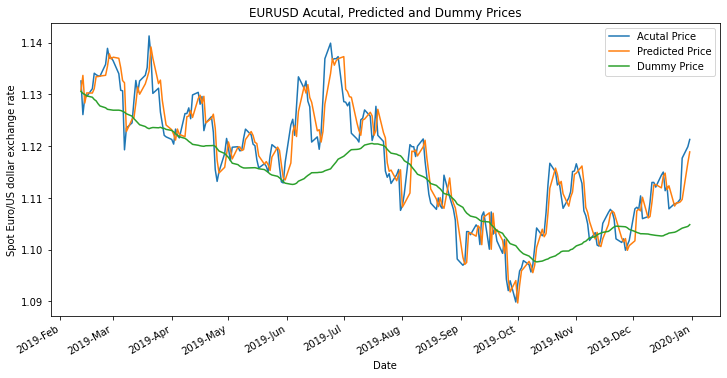

In [20]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str)

plotter.single_plot()

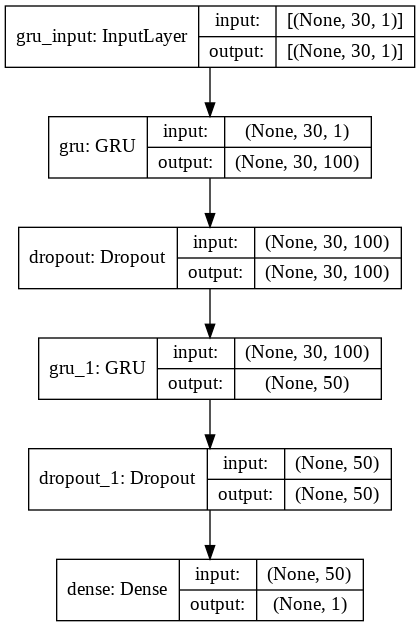

In [21]:
plot_model(model, show_shapes=True, expand_nested=True)

In [22]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)

MSE:  0.015873705623312227
RMSE:  0.12599089500163188
MAE:  0.10707004801482177


In [23]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE:'+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n')
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_EURUSD/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/GRU_EURUSD/assets
